In [1]:
import pandas as pd

df = pd.read_csv('train.csv')
df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [2]:
x = df.drop('ACTION', axis=1)
y = df.ACTION

In [3]:
cat_features = list(range(0, len(x.columns)))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [4]:
print('Label: {}'.format(set(y)))
print('Zero % = {} %\nOne % = {} %'.format((len(y) - sum(y))*100/len(y), sum(y)*100/len(y)))

Label: {0, 1}
Zero % = 5.789007903811529 %
One % = 94.21099209618848 %


In [5]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=500)
model.fit(x, y, cat_features=cat_features, verbose=100)

Learning rate set to 0.086314
0:	learn: 0.5952566	total: 87.3ms	remaining: 43.6s
100:	learn: 0.1461604	total: 4.61s	remaining: 18.2s
200:	learn: 0.1387989	total: 9.65s	remaining: 14.3s
300:	learn: 0.1330055	total: 14.3s	remaining: 9.43s
400:	learn: 0.1277795	total: 19.3s	remaining: 4.77s
499:	learn: 0.1224644	total: 24.9s	remaining: 0us


In [6]:
from catboost import Pool
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0)

train_pool = Pool(
                    data = x_train,
                    label = y_train,
                    cat_features = cat_features
)

val_pool = Pool(
                    data = x_val,
                    label = y_val,
                    cat_features = cat_features
)

In [7]:
model = CatBoostClassifier(
                            iterations=200,
                            learning_rate=0.03,
                            custom_loss=['AUC', 'Accuracy'],
                            eval_metric='AUC',
#                             early_stopping_rounds=20
)

model.fit(
            train_pool,
            eval_set = val_pool,
            verbose = False,
            plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [8]:
print(model.predict_proba(x_val))

[[0.03126069 0.96873931]
 [0.02267694 0.97732306]
 [0.01142188 0.98857812]
 ...
 [0.04158451 0.95841549]
 [0.02799489 0.97200511]
 [0.01945732 0.98054268]]


In [9]:
import matplotlib.pyplot as plt
from catboost.utils import get_roc_curve, get_fpr_curve, get_fnr_curve

curve = get_roc_curve(model, val_pool)
(fpr, tpr, thresholds) = curve
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

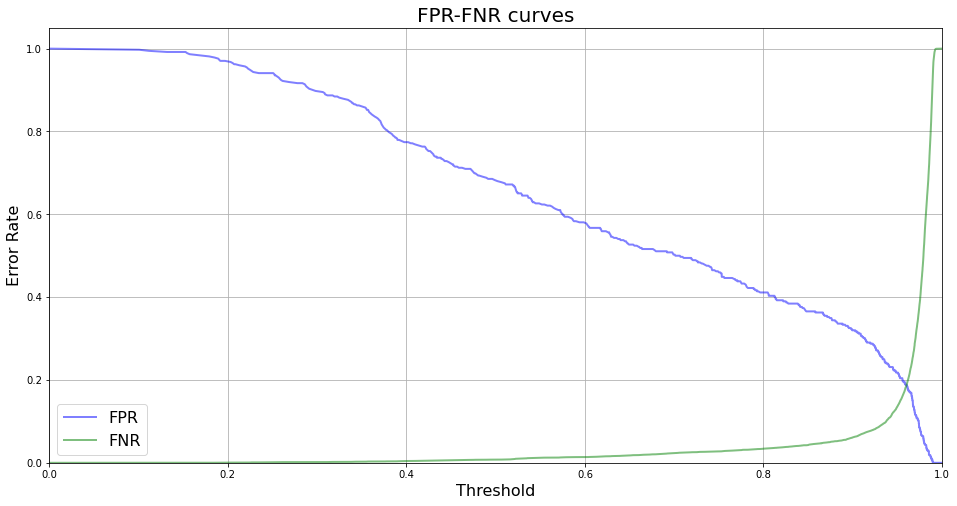

In [10]:
plt.figure(figsize=(16, 8))
style = {'alpha': 0.5, 'lw':2}

plt.plot(thresholds, fpr, color = 'blue', label = 'FPR', **style)
plt.plot(thresholds, fnr, color = 'green', label = 'FNR', **style)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc = 'lower left', fontsize=16)

In [11]:
from catboost.utils import select_threshold

# print(select_threshold(model, val_pool, FNR=0.01))
print(select_threshold(model, val_pool, FPR=0.03))

0.9836392204844719


setting margine as 0.95

In [12]:
prediction = model.predict_proba(x_val)
print(type(prediction))

<class 'numpy.ndarray'>


In [13]:
def predict_this(model, x):
    prediction = model.predict_proba(x)
#     margin = 0.98
    y_pred = [prediction[i][1] for i in range(len(prediction))]
#     for i in range(len(prediction)):
#         if prediction[i][0] >= margin or prediction[i][1] >= margin:
#             y_pred.append(1)
#         else:
#             y_pred.append(0)
    return y_pred

In [14]:
y_pred = predict_this(model, x_val)

In [15]:
print(len(y_pred))
print(len(prediction))

6554
6554


In [16]:
from sklearn import metrics

In [17]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred, pos_label=1)
auc = metrics.auc(fpr,tpr)
auc

0.8955058998897251

In [18]:
shap_values = model.get_feature_importance(
    val_pool,
    'ShapValues'
)
expected_value = shap_values[0,-1]
shap_values = shap_values[:, :-1]
print(shap_values.shape)

(6554, 9)


In [19]:
proba = model.predict_proba([x.iloc[1,:]])[0]
raw = model.predict([x.iloc[1,:]], prediction_type='RawFormulaVal')[0]

from numpy import exp
sigmoid = lambda x: 1 / (1 + exp(-x))

print('Probabilities:', proba)
print('Raw formula value %.4f' % raw)
print('Probability from raw value %.4f' % sigmoid(raw))

Probabilities: [0.01240892 0.98759108]
Raw formula value 4.3769
Probability from raw value 0.9876


In [20]:
import shap

# shap.initjs()
# shap.force_plot(expected_value, shap_values[1,:], x_val.iloc[1,:])

In [25]:
shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], x_val.iloc[1,:])

In [26]:
expected_value

3.374797315120617

In [27]:
shap_values[1,:]

array([-0.30383443,  0.14088009,  0.03750086,  0.09711137,  0.00190958,
        0.12279295,  0.10250301,  0.05837457,  0.13143333])

In [28]:
x_val.iloc[1,:]

RESOURCE             25240
MGR_ID               14815
ROLE_ROLLUP_1       117961
ROLE_ROLLUP_2       118327
ROLE_DEPTNAME       118320
ROLE_TITLE          123045
ROLE_FAMILY_DESC    123107
ROLE_FAMILY         120518
ROLE_CODE           123047
Name: 19639, dtype: int64

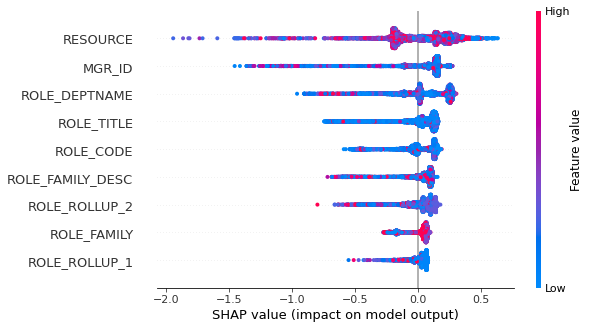

In [29]:
shap.summary_plot(shap_values, x_val)

In [21]:
test_df = pd.read_csv("test.csv")
test_x = test_df.drop(["id"], axis = 1)
test_x.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,42093,50015,117961,118343,119598,118422,300136,118424,118425


In [22]:
model1 = CatBoostClassifier(
                            iterations=1000,
                            learning_rate=0.03,
                            eval_metric='AUC',
)

model1.fit(x, y, cat_features=cat_features, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [23]:
pool = Pool(
             data = x_val,
             label = y_val,
             cat_features = cat_features
)
print(select_threshold(model1, train_pool, FPR=0))
print(select_threshold(model1, train_pool, FNR=0.01))

0.9869208703406526
0.7460835231630973


In [24]:
y_pred = predict_this(model1, test_x)
output = pd.DataFrame({'id': test_df.id, 'ACTION': y_pred})
output.to_csv('my_submission_1.csv', index=False)